In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn import svm
from mpl_toolkits.mplot3d import axes3d, Axes3D
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
dataset = pd.read_csv("data.csv")
dataset.head()
stock = dataset

In [3]:
stock.Date = pd.to_datetime(stock.Date, format='%Y%m%d', errors='ignore')

In [4]:
stock = stock.dropna()
#stock = stock.isnull()
stock = stock[['Date','Open', 'High', 'Low', 'Close']]

In [5]:
stock = stock.groupby('Date')['Close'].sum().reset_index()
stock.head()

,Date,Close
0,2012-01-01,879.0
1,2012-01-02,900.0
2,2012-01-03,892.0
3,2012-01-04,865.0
4,2012-01-05,858.0


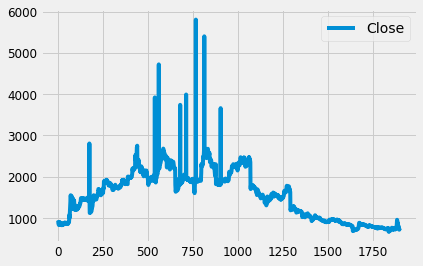

In [6]:
stock.plot()

In [7]:
len(stock)


1901

In [8]:
##normalizing data 
data_n = (stock['Close'] -stock['Close'].min() )/(stock['Close'].max()- stock['Close'].min())

In [9]:
data_n


0       0.041261
1       0.045348
2       0.043791
3       0.038536
4       0.037174
          ...   
1896    0.016154
1897    0.012456
1898    0.009342
1899    0.012262
1900    0.006617
Name: Close, Length: 1901, dtype: float64

In [10]:
dimensions = 12
data_cn = pd.concat([data_n.shift(i) for i in range(0 + dimensions + 1)], axis = 1)

print(data_cn)

         Close     Close     Close     Close     Close     Close     Close  \
0     0.041261       NaN       NaN       NaN       NaN       NaN       NaN   
1     0.045348  0.041261       NaN       NaN       NaN       NaN       NaN   
2     0.043791  0.045348  0.041261       NaN       NaN       NaN       NaN   
3     0.038536  0.043791  0.045348  0.041261       NaN       NaN       NaN   
4     0.037174  0.038536  0.043791  0.045348  0.041261       NaN       NaN   
...        ...       ...       ...       ...       ...       ...       ...   
1896  0.016154  0.016154  0.023939  0.028805  0.021214  0.033671  0.035033   
1897  0.012456  0.016154  0.016154  0.023939  0.028805  0.021214  0.033671   
1898  0.009342  0.012456  0.016154  0.016154  0.023939  0.028805  0.021214   
1899  0.012262  0.009342  0.012456  0.016154  0.016154  0.023939  0.028805   
1900  0.006617  0.012262  0.009342  0.012456  0.016154  0.016154  0.023939   

         Close     Close     Close     Close     Close     Clos

In [11]:
from sklearn.model_selection import train_test_split

X = data_cn.iloc[12:,1:]

y = data_cn.iloc[12:,0]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.4, shuffle = False)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, shuffle = False)


print(len(y_val))
print(len(y_test))
print(len(y_train))

378
378
1133


In [12]:
def pso(n_particles, iterations, dimensions, inertia):

    # Range of SVR's hyperparameters (Particles' search space)
    # C, Epsilon and Gamma
    max_c = 1e4
    min_c = 1e-3
    max_e = 1e-1
    min_e = 1e-8
    max_g = 1e3
    min_g = 1e-3
    
    # Initializing particles' positions randomly, inside
    # the search space
    x = np.random.rand(n_particles, 1)*(max_c - min_c) + min_c
    y = np.random.rand(n_particles, 1)*(max_e - min_e) + min_e
    z = np.random.rand(n_particles, 1)*(max_g - min_g) + min_g

    c = np.concatenate((x,y,z), axis=1)

    # Initializing particles' parameters
    v = np.zeros((n_particles, dimensions))
    c1 = 2
    c2 = 2
    p_best = np.zeros((n_particles, dimensions))
    p_best_val = np.zeros(n_particles) + sys.maxsize  
    g_best = np.zeros(dimensions)
    g_best_val = sys.maxsize

    best_iter = np.zeros(iterations)

    # Initializing regression variables
    p_best_RGS = np.empty((n_particles), dtype = object);
    g_best_RGS = sys.maxsize

    

    # Displaying tridimensional search space
    plot(c)

    from sklearn.metrics import mean_squared_error
    
    for i in range(iterations):

        for j in range(n_particles):
          # Starting Regression
          rgs = svm.SVR(C = c[j][0], epsilon = c[j][1], gamma = c[j][2])

          # Fitting the curve
          rgs.fit(X_train, y_train)
          y_predict = rgs.predict(X_val)

          # Using Mean Squared Error to verify prediction accuracy
          mse = mean_squared_error(y_val, y_predict) 

          # If mse value for that search point, for that particle,
          # is less than its personal best point,
          # replace personal best
          if(mse < p_best_val[j]):   # mse < p_best_val[j]
              # The value below represents the current least Mean Squared Error
              p_best_val[j] = mse
              
              p_best_RGS[j] = rgs
                           

              # The value below represents the current search coordinates for
              # the particle's current least Mean Squared Error found
              p_best[j] = c[j].copy()
              
          # Using auxiliar variable to get the index of the
          # particle that found the configuration with the 
          # minimum MSE value
          aux = np.argmin(p_best_val)        
        
          if(p_best_val[aux] < g_best_val):
              # Assigning Particle's current best MSE to the Group's best    
              g_best_val = p_best_val[aux]

              # Assigning Particle's current best configuration to the Group's best
              g_best = p_best[aux].copy()

              # Group best regressor:
              # the combination of C, Epsilon and Gamma
              # that computes the best fitting curve
              g_best_RGS = p_best_RGS[aux]

        
          rand1 = np.random.random()
          rand2 = np.random.random()

          # The variable below influences directly the particle's velocity.
          # It can either make it smaller or bigger. 
          w = inertia

          # The equation below represents Particle's velocity, which is
          # the rate of change in its position
          v[j] = w*v[j] + c1*(p_best[j] - c[j])*rand1 + c2*(g_best - c[j])*rand2

          # Change in the Particle's position 
          c[j] = c[j] + v[j]

          # Below is a series of conditions that stop the particles from
          # leaving the search space
          if(c[j][2] < min_g):
            c[j][2] = min_g
          if(c[j][2] > max_g):
            c[j][2] = max_g
          if(c[j][1] < min_e):
            c[j][1] = min_e
          if(c[j][1] > max_e):
            c[j][1] = max_e
          if(c[j][0] < min_c):
            c[j][0] = min_c
          if(c[j][0] > max_c):
            c[j][0] = max_c
            
     
        # The variable below represents the least Mean Squared Error
        # of the current iteration
        best_iter[i] = g_best_val
                
        print('Best value iteration # %d = %f\n'%(i, g_best_val))

    # Coordinates found after all the iterations
    print('Group Best configuration found: ')
    print(g_best)
    print('\n')
    print('Best Regressor:\n')
    print(g_best_RGS)
    print('\n')
    # Displaying the MSE value variation throughout the iterations
    t = range(iterations)
    plt.plot(t, best_iter, label='Fitness Value')
    plt.legend()
    plt.show()

    # Displaying Particles' final configuration
    plot(c)

    # Making the prediction with the best configuration of C, Epsilon and
    # Gamma found by the particles
    predict_test = g_best_RGS.predict(X_test)

    
    # Displaying actual values and predicted values for
    # Group's best configuration found overall
    print(color.BOLD + 'Predictions with the Population Best Value found:\n' + color.END)
    evaluate(predict_test)

In [13]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [14]:
def plot(some_list):
 
  ax = Axes3D(plt.figure())
  ax.scatter3D(some_list[:,0], some_list[:,1], some_list[:,2], color = 'r')
  ax.set_xlabel('$C$', fontsize = 20)
  ax.set_ylabel('$\epsilon$', fontsize = 25)
  ax.zaxis.set_rotate_label(False) 
  ax.set_zlabel('$\gamma$', fontsize=30, rotation = 0)
  ax.zaxis._axinfo['label']['space_factor'] = 1.0
  plt.show()

  print('\n')
  print('\n')

In [15]:
def evaluate(predictions):

    from sklearn.metrics import mean_squared_error
    import statistics as st

    predict_test = predictions

    # To un-normalize the data:
    # Multiply the values by
    # data.to_numpy().max()

    plt.plot(range(len(y_test)), y_test, label='Real')
    plt.plot(range(len(predict_test)), predict_test, label='Predicted')
    plt.legend()
    plt.show()
    
    mse = mean_squared_error(y_test, predict_test)
    print('\n')
    print('\n')
    print('Mean Squared Error for the Test Set:\t %f' %mse)
    print('\n')
    print('\n')
    print('Predictions Average:\t %f' %((predict_test.sum()/len(predict_test))))
    print('\n')
    print('\n')
    print('Predictions Median:\t %f' %(st.median(predict_test)))
    print('\n')
    print('\n')


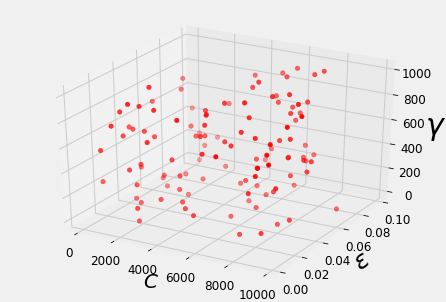





Best value iteration # 0 = 0.000237

Best value iteration # 1 = 0.000035

Best value iteration # 2 = 0.000035

Best value iteration # 3 = 0.000035

Best value iteration # 4 = 0.000034

Best value iteration # 5 = 0.000034

Best value iteration # 6 = 0.000034

Best value iteration # 7 = 0.000034

Best value iteration # 8 = 0.000034

Best value iteration # 9 = 0.000034

Best value iteration # 10 = 0.000034

Best value iteration # 11 = 0.000034

Best value iteration # 12 = 0.000034

Best value iteration # 13 = 0.000034

Best value iteration # 14 = 0.000034

Best value iteration # 15 = 0.000034

Best value iteration # 16 = 0.000034

Best value iteration # 17 = 0.000034

Best value iteration # 18 = 0.000034

Best value iteration # 19 = 0.000034

Best value iteration # 20 = 0.000034

Best value iteration # 21 = 0.000034

Best value iteration # 22 = 0.000034

Best value iteration # 23 = 0.000034

Best value iteration # 24 = 0.000034

Best value iteration # 25 = 0.000034

Best value iterati

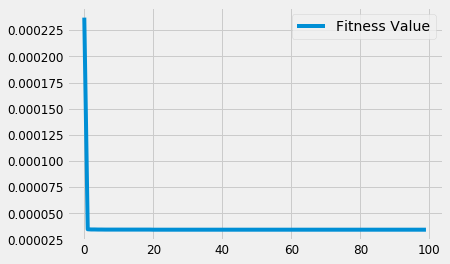

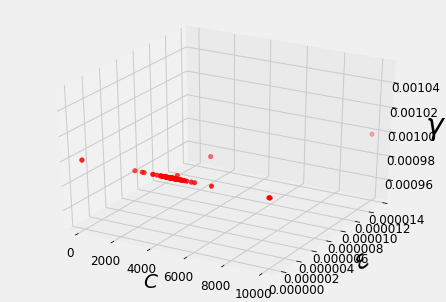





Predictions with the Population Best Value found:



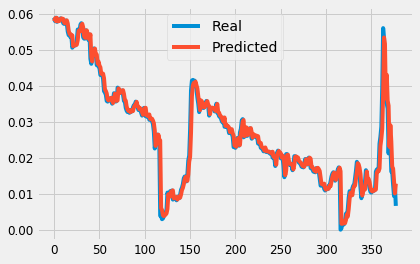





Mean Squared Error for the Test Set:	 0.000008




Predictions Average:	 0.027333




Predictions Median:	 0.025688






In [16]:
#pso(120, 100, 3, 0.2)
#pso(120, 100, 3, 0.2)
pso(120, 100, 3, 0.2)